# Brill Tagger Syllabifier

Trains a **Unigram → Bigram → Brill** tagger chain to predict syllable boundaries (B/I labels) from the Portuguese Phonetic Lexicon dataset.

**Pipeline:**
1. Load dataset from HuggingFace
2. Prepare sequence-labelling data per region
3. Train Unigram → Bigram → Brill tagger chain
4. Evaluate & benchmark
5. Export model (pickle)
6. MLflow tracking
7. Upload to HuggingFace Hub (optional)

## 1. Install Dependencies

In [38]:
!pip install datasets nltk joblib mlflow scikit-learn huggingface_hub onnx onnxruntime onnxscript numpy matplotlib tqdm

print("All packages installed.")


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
All packages installed.


## 2. Configuration (env vars)

In [39]:
import os

def _env(key, default=""):
    return os.environ.get(key, default)

def _flag(key, default=False):
    v = os.environ.get(key, str(default)).lower()
    return v in ("1", "true", "yes")

# ── Dataset ──────────────────────────────────────────────────────────────────
REPO_ID          = _env("REPO_ID",         "TigreGotico/portuguese_phonetic_lexicon")
DATASET_SPLIT    = _env("DATASET_SPLIT",   "train")
WORD_COLUMN      = _env("WORD_COLUMN",     "word")
SYLLABLES_COLUMN = _env("SYLLABLES_COLUMN","syllables")   # pipe-separated: "ca|sa"
REGION_COLUMN    = _env("REGION_COLUMN",   "region_code")

# Comma-separated list; empty = train all regions found in the dataset
REGIONS          = [r.strip() for r in _env("REGIONS", "lbx").split(",") if r.strip()]

# ── Training ─────────────────────────────────────────────────────────────────
TEST_SIZE        = float(_env("TEST_SIZE",  "0.1"))
BRILL_MAX_RULES  = int  (_env("BRILL_MAX_RULES", "100"))
BRILL_MIN_SCORE  = int  (_env("BRILL_MIN_SCORE", "3"))
N_JOBS           = int  (_env("N_JOBS",     "-1"))   # joblib parallelism
RANDOM_SEED      = int  (_env("RANDOM_SEED","42"))

# ── Output paths ─────────────────────────────────────────────────────────────
OUTPUT_DIR       = _env("OUTPUT_DIR", "./syllabifier_output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── ONNX ─────────────────────────────────────────────────────────────────────
ONNX_QUANTIZE    = _flag("ONNX_QUANTIZE", True)   # quantise to INT8 where possible

# ── MLflow ───────────────────────────────────────────────────────────────────
MLFLOW_TRACKING_URI = _env("MLFLOW_TRACKING_URI", f"{OUTPUT_DIR}/mlruns")
MLFLOW_EXPERIMENT   = _env("MLFLOW_EXPERIMENT",   "brill_syllabifier")

# ── HuggingFace ──────────────────────────────────────────────────────────────
HF_TOKEN         = _env("HF_TOKEN", "")
HF_UPLOAD        = _flag("HF_UPLOAD", False)
HF_UPLOAD_REPO   = _env("HF_UPLOAD_REPO", "")

print("Configuration:")
print(f"  REPO_ID          = {REPO_ID}")
print(f"  REGIONS          = {REGIONS}")
print(f"  TEST_SIZE        = {TEST_SIZE}")
print(f"  BRILL_MAX_RULES  = {BRILL_MAX_RULES}")
print(f"  BRILL_MIN_SCORE  = {BRILL_MIN_SCORE}")
print(f"  N_JOBS           = {N_JOBS}")
print(f"  OUTPUT_DIR       = {OUTPUT_DIR}")
print(f"  ONNX_QUANTIZE    = {ONNX_QUANTIZE}")
print(f"  HF_UPLOAD        = {HF_UPLOAD}")
print(f"  MLFLOW_TRACKING  = {MLFLOW_TRACKING_URI}")

Configuration:
  REPO_ID          = TigreGotico/portuguese_phonetic_lexicon
  REGIONS          = ['lbx']
  TEST_SIZE        = 0.1
  BRILL_MAX_RULES  = 100
  BRILL_MIN_SCORE  = 3
  N_JOBS           = -1
  OUTPUT_DIR       = ./syllabifier_output
  ONNX_QUANTIZE    = True
  HF_UPLOAD        = False
  MLFLOW_TRACKING  = ./syllabifier_output/mlruns


## 3. NLTK data

In [40]:
import nltk
nltk.download("punkt", quiet=True)
print("NLTK data ready.")

NLTK data ready.


## 4. Load Dataset

In [41]:
import random
from datasets import load_dataset

print(f"Loading dataset '{REPO_ID}' split='{DATASET_SPLIT}' …")

load_kwargs = {"split": DATASET_SPLIT}
if HF_TOKEN:
    load_kwargs["token"] = HF_TOKEN

raw_dataset = load_dataset(REPO_ID, **load_kwargs)

# Filter: keep only entries that have both syllables and valid columns
entries = [
    row for row in raw_dataset
    if row.get(SYLLABLES_COLUMN) and row.get(WORD_COLUMN)
]

random.seed(RANDOM_SEED)
random.shuffle(entries)

# Discover available regions
available_regions = sorted({row[REGION_COLUMN] for row in entries if REGION_COLUMN in row})
print(f"Total valid entries : {len(entries):,}")
print(f"Available regions   : {available_regions}")

# If no regions were specified in env, train all
if not REGIONS:
    REGIONS = available_regions
    print(f"REGIONS not set – defaulting to all: {REGIONS}")
else:
    REGIONS = [r for r in REGIONS if r in available_regions]
    print(f"Training regions    : {REGIONS}")

Loading dataset 'TigreGotico/portuguese_phonetic_lexicon' split='train' …
Total valid entries : 616,716
Available regions   : ['dli', 'lbn', 'lbx', 'lda', 'map', 'mpx', 'rjo', 'rjx', 'spo', 'spx']
Training regions    : ['lbx']


## 5. Data Preparation

In [42]:
def validate_entry(entry):
    """Check that syllables reconstruct the original word."""
    word      = entry[WORD_COLUMN]
    syllables = entry[SYLLABLES_COLUMN].split("|")
    return "".join(syllables).lower() == word.replace("-", "").lower()


def prepare_dataset(entries, region):
    """
    Convert word/syllable entries into character-level B/I label sequences.

    B = first character of a syllable
    I = continuation
    """
    X, y = [], []
    bad = 0
    for entry in entries:
        if entry.get(REGION_COLUMN) != region:
            continue
        if not validate_entry(entry):
            bad += 1
            continue

        word      = entry[WORD_COLUMN]
        syllables = entry[SYLLABLES_COLUMN].split("|")
        labels    = ["I"] * len(word)
        idx = 0
        try:
            for syl in syllables:
                labels[idx] = "B"
                idx += len(syl)
        except IndexError:
            bad += 1
            continue

        X.append(list(word))
        y.append(labels)

    print(f"[{region}] entries={len(X):,}  skipped={bad}")
    return X, y


def to_nltk_format(X, y):
    """Convert parallel lists into NLTK-style tagged sentences."""
    return [list(zip(chars, labels)) for chars, labels in zip(X, y)]


print("Data preparation helpers defined.")

Data preparation helpers defined.


## 6. Tagger Training

In [43]:
import joblib
from sklearn.model_selection import train_test_split
from nltk.tag import UnigramTagger, BigramTagger, DefaultTagger, brill, brill_trainer


def train_for_region(region, entries):
    print(f"\n{'='*60}")
    print(f"Training region: {region}")

    X, y = prepare_dataset(entries, region)
    if not X:
        print(f"[{region}] No data – skipping.")
        return None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
    )

    train_data = to_nltk_format(X_train, y_train)
    test_data  = to_nltk_format(X_test,  y_test)

    # Tagger chain: DefaultTagger → Unigram → Bigram → Brill
    default_tagger  = DefaultTagger("I")
    unigram_tagger  = UnigramTagger(train_data, backoff=default_tagger)
    bigram_tagger   = BigramTagger (train_data, backoff=unigram_tagger)

    trainer      = brill_trainer.BrillTaggerTrainer(
        initial_tagger=bigram_tagger,
        templates=brill.fntbl37(),
    )
    brill_tagger = trainer.train(
        train_data,
        max_rules=BRILL_MAX_RULES,
        min_score=BRILL_MIN_SCORE,
    )

    # Accuracy
    uni_acc   = unigram_tagger.accuracy(test_data)
    bi_acc    = bigram_tagger .accuracy(test_data)
    brill_acc = brill_tagger  .accuracy(test_data)
    n_rules   = len(brill_tagger.rules())

    print(f"[{region}] Unigram={uni_acc:.4f}  Bigram={bi_acc:.4f}  Brill={brill_acc:.4f}  rules={n_rules}")

    # Persist
    model_path = os.path.join(OUTPUT_DIR, f"{region}_brill_syllabifier.pkl")
    if not os.path.exists(model_path):
        joblib.dump(brill_tagger, model_path)
        print(f"Saved → {model_path}")
    else:
        print(f"Model already exists, skipping save: {model_path}")

    return {
        "region"   : region,
        "n_train"  : len(X_train),
        "n_test"   : len(X_test),
        "unigram"  : uni_acc,
        "bigram"   : bi_acc,
        "brill"    : brill_acc,
        "n_rules"  : n_rules,
        "model_path": model_path,
        "tagger"   : brill_tagger,
        "test_data": test_data,
        "X_test"   : X_test,
        "y_test"   : y_test,
    }


print("Training function defined.")

Training function defined.


In [44]:
from joblib import Parallel, delayed

results_list = Parallel(n_jobs=N_JOBS, prefer="threads")(
    delayed(train_for_region)(region, entries) for region in REGIONS
)

results = {r["region"]: r for r in results_list if r is not None}
print(f"\nTrained {len(results)} region(s): {list(results.keys())}")


Training region: lbx
[lbx] entries=61,673  skipped=0
[lbx] Unigram=0.8309  Bigram=0.8560  Brill=0.9869  rules=100
Model already exists, skipping save: ./syllabifier_output/lbx_brill_syllabifier.pkl

Trained 1 region(s): ['lbx']


## 7. MLflow Tracking

In [45]:
import mlflow

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT)

for region, r in results.items():
    with mlflow.start_run(run_name=region):
        mlflow.log_params({
            "region"        : region,
            "repo_id"       : REPO_ID,
            "test_size"     : TEST_SIZE,
            "brill_max_rules": BRILL_MAX_RULES,
            "brill_min_score": BRILL_MIN_SCORE,
            "n_train"       : r["n_train"],
            "n_test"        : r["n_test"],
        })
        mlflow.log_metrics({
            "unigram_acc" : r["unigram"],
            "bigram_acc"  : r["bigram"],
            "brill_acc"   : r["brill"],
            "n_brill_rules": r["n_rules"],
        })
        mlflow.log_artifact(r["model_path"])

print("MLflow runs logged.")

MLflow runs logged.


## 11. Plots

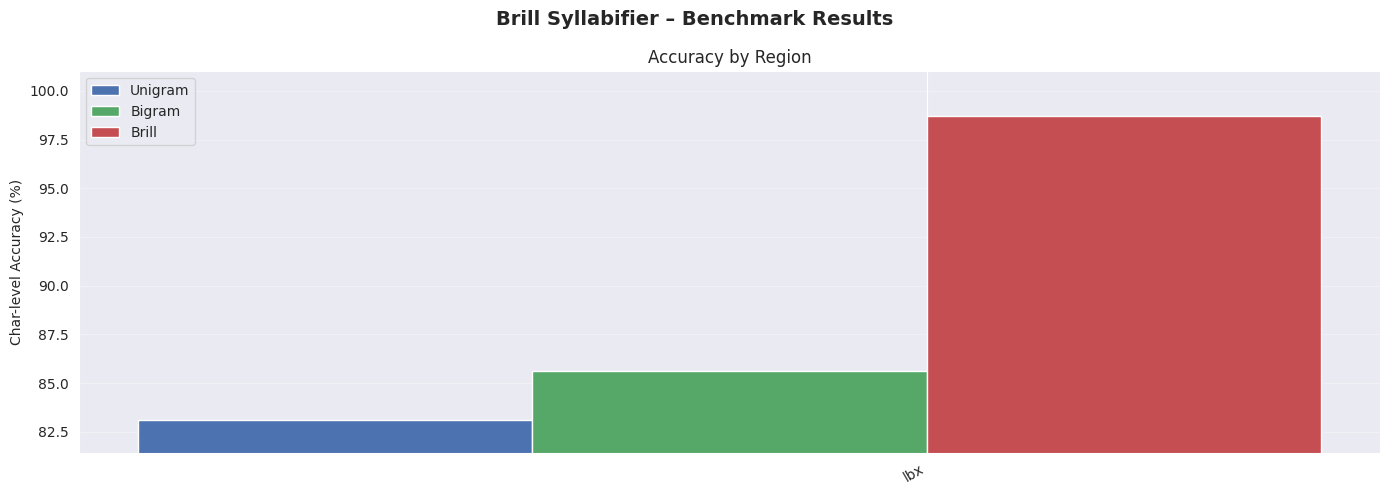

Plot saved → ./syllabifier_output/benchmark.png


In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np


uni_accs   = [results[r]["unigram"] * 100 for r in results]
bi_accs    = [results[r]["bigram"]  * 100 for r in results]
brill_accs = [results[r]["brill"]   * 100 for r in results]

x      = np.arange(len(results))
width  = 0.2

fig, ax = plt.subplots(1, 1, figsize=(14, 5))
fig.suptitle("Brill Syllabifier – Benchmark Results", fontsize=14, fontweight="bold")

# ── Accuracy comparison ───────────────────────────────────────────────────────
ax.bar(x - 1.5*width, uni_accs,   width, label="Unigram",  color="#4C72B0")
ax.bar(x - 0.5*width, bi_accs,    width, label="Bigram",   color="#55A868")
ax.bar(x + 0.5*width, brill_accs, width, label="Brill",    color="#C44E52")
ax.set_xticks(x)
ax.set_xticklabels(results, rotation=30, ha="right")
ax.set_ylabel("Char-level Accuracy (%)")
ax.set_title("Accuracy by Region")
ax.legend()
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.1f"))
ax.set_ylim(min(uni_accs) * 0.98, 101)
ax.grid(axis="y", alpha=0.3)


plt.tight_layout()
plot_path = os.path.join(OUTPUT_DIR, "benchmark.png")
plt.savefig(plot_path, dpi=120, bbox_inches="tight")
plt.show()
print(f"Plot saved → {plot_path}")

In [47]:
# ── Summary table ─────────────────────────────────────────────────────────────
print(f"\n{'Region':<8} | {'Train':>7} | {'Test':>6} | "
      f"{'Unigram':>8} | {'Bigram':>7} | {'Brill':>7} | "
      f"{'N Rules':>6}")
print("-" * 70)
for region in results:
    r  = results[region]
    br = results[region]
    print(
        f"{region:<8} | {r['n_train']:>7,} | {r['n_test']:>6,} | "
        f"{r['unigram']*100:>7.2f}% | {r['bigram']*100:>6.2f}% | "
        f"{r['brill']*100:>6.2f}% | {r['n_rules']:>6}"
    )


Region   |   Train |   Test |  Unigram |  Bigram |   Brill | N Rules
----------------------------------------------------------------------
lbx      |  55,505 |  6,168 |   83.09% |  85.60% |  98.69% |    100


## 12. Qualitative Verification

In [48]:
PROBE_WORDS = ["computador", "saudade", "telefone", "universidade", "apartamento"]

print(f"{'Word':<20}", end="")
for region in results:
    print(f" | {region:^14}", end="")
print()
print("-" * (20 + 17 * len(results)))

def syllabify(tagger, word: str):
    """
    Split a Portuguese word into syllables using IOB tagging.

    Args:
        word (str): The input word to be syllabified.

    Returns:
        List[str]: A list of syllables as strings.
    """
    tags = tagger.tag(list(word))
    syllables = []
    current = ""

    for char, tag in tags:
        if tag == "B" and current:
            syllables.append(current)
            current = char
        else:
            current += char

    if current:
        syllables.append(current)

    return syllables

for word in PROBE_WORDS:
    print(f"{word:<20}", end="")
    for region in results:
        tagger =results[region]["tagger"]
        pred = syllabify(tagger, word)
        print(pred)


Word                 |      lbx      
-------------------------------------
computador          ['com', 'pu', 'ta', 'dor']
saudade             ['sau', 'da', 'de']
telefone            ['te', 'le', 'fo', 'ne']
universidade        ['u', 'ni', 'ver', 'si', 'da', 'de']
apartamento         ['a', 'par', 'ta', 'men', 'to']


## 13. Upload to HuggingFace Hub (optional)

In [49]:
if HF_UPLOAD:
    if not HF_TOKEN:
        print("HF_TOKEN not set – skipping upload.")
    elif not HF_UPLOAD_REPO:
        print("HF_UPLOAD_REPO not set – skipping upload.")
    else:
        from huggingface_hub import HfApi
        api = HfApi(token=HF_TOKEN)
        api.create_repo(HF_UPLOAD_REPO, repo_type="model", exist_ok=True)

        for region, r in results.items():
            # Upload pkl
            api.upload_file(
                path_or_fileobj=r["model_path"],
                path_in_repo=os.path.basename(r["model_path"]),
                repo_id=HF_UPLOAD_REPO,
                repo_type="model",
            )

        # Upload plots
        api.upload_file(
            path_or_fileobj=plot_path,
            path_in_repo=os.path.basename(plot_path),
            repo_id=HF_UPLOAD_REPO,
            repo_type="model",
        )

        print(f"All files uploaded to https://huggingface.co/{HF_UPLOAD_REPO}")
else:
    print("HF_UPLOAD=False – skipping upload.")

HF_UPLOAD=False – skipping upload.
